In [1]:
from cirq_bifurcation_rg import *

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


Here we'll explore the effect of 'correcting' a hamiltonian

by this I mean 

1) apply sbrg to $H$ to obtain cliffords 

2) apply the cliffords to $H$ to obtain $H_d + H'$, where $H'$ is off-diagonal

3) apply the inverse of the cliffords to $H_d$ to obtain $H_{corrected}$. This is the hamiltonian such that when we apply the cliffords, we diagonalize the hamiltonian. 

In [2]:
a, b, c = give_dist(10**4, 1, 1, 1, 1)

In [3]:
a

array([0.49595239, 0.9066127 , 0.77943074, ..., 0.83586187, 0.64562314,
       0.90301314])

In [4]:
bins = [0 for _ in range(10**2)]

xs = np.linspace(0, 1, 10**2)

dx = xs[1]-xs[0]

for l in [a, b, c]:
    for v in l:
        index = int(v//dx)
        
        bins[index] += 1

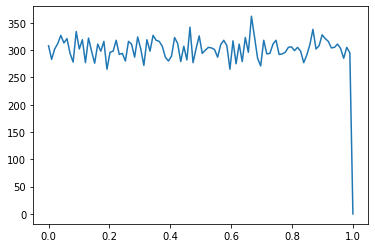

In [5]:
plt.plot(xs, bins)

In [6]:
ham_generator = give_tfim_1d_hamiltonian_generator(
    n=10,
    j0=1,
    k0=0,
    h0=1,
    gamma0=1,
    periodic=True,
)

In [7]:
test_ham = ham_generator()

In [191]:
def obtain_corrected_hamiltonian(
    hamiltonian: cirq.PauliSum,
    return_other_hamiltonians: bool = False,
    preserve_locality: bool = False,
    growth_rate: int = 2,
) -> Union[cirq.PauliSum, Tuple[cirq.PauliSum, cirq.PauliSum]]:
    """
    
    """
    sbrg_object=BifurcationRG(
        hamiltonian=hamiltonian.copy(),
        growth_rate=growth_rate,
    )
    
    sbrg_object.diagonalize()

    cliffords = sbrg_object.clifford_rotations
    
    clifford_diagonalized_hamiltonian = sbrg_object.apply_clifford_diagonalization(
        hamiltonian.copy(),
        preserve_locality=preserve_locality,
        cliffords_list=cliffords,
    )
    
    diagonal_part = cirq.PauliSum()
    off_diagonal_part = cirq.PauliSum()
    
    for term in clifford_diagonalized_hamiltonian:
        if {cirq.X, cirq.Y}.intersection(set(term.values())):
            off_diagonal_part += term
            
        else:
            diagonal_part += term
    
    inverted_unperturbed_cliffords = sbrg_object.invert_cliffords(
        cliffords
    )
    
    corrected_hamiltonian = sbrg_object.apply_clifford_diagonalization(
        diagonal_part,
        cliffords_list=inverted_unperturbed_cliffords
    )
    
    if return_other_hamiltonians:
        return corrected_hamiltonian, clifford_diagonalized_hamiltonian, diagonal_part, off_diagonal_part
    
    return corrected_hamiltonian


In [9]:
def test_clifford_inversion(
    hamiltonian: cirq.PauliSum,
    test_hamiltonian: cirq.PauliSum,
    preserve_locality: bool = False,
) -> cirq.PauliSum:
    """
    
    """
    sbrg_object=BifurcationRG(
        hamiltonian=hamiltonian.copy()
    )
    
    sbrg_object.diagonalize()

    cliffords = sbrg_object.clifford_rotations
    
    inverted_cliffords = sbrg_object.invert_cliffords(
        cliffords
    )
    
    clifford_diagonalized_test_hamiltonian = sbrg_object.apply_clifford_diagonalization(
        test_hamiltonian,
        preserve_locality=preserve_locality,
        cliffords_list=cliffords,
    )
    
    clifford_undiagonalized_test_hamiltonian = sbrg_object.apply_clifford_diagonalization(
        clifford_diagonalized_test_hamiltonian,
        preserve_locality=preserve_locality,
        cliffords_list=inverted_cliffords,
    )
    
    return (
        test_hamiltonian, 
        clifford_undiagonalized_test_hamiltonian
    )
    
    

In [36]:
def determine_energy_variance(
    hamiltonian: cirq.PauliSum,
    N: int,
) -> Tuple[float, float]:
    """
    """
    
    squared_ham = hamiltonian**2
    
    trace_of_squared_ham = N * squared_ham._linear_dict[frozenset()]
    
    diag_ham = cirq.PauliSum()
    
    for term in hamiltonian:
        
        if not {cirq.X, cirq.Y}.intersection(set(term.values())):
            # Then its diagonal
            diag_ham+=term
    
    squared_diag_ham = diag_ham**2
    
    trace_of_squared_diag_ham = N * squared_diag_ham._linear_dict[frozenset()]
    
    #print("~~~~~~~~~~~~~")
    #print(trace_of_squared_ham, trace_of_squared_diag_ham)
    #print("~~~~~~~~~~~~~")
    
    assert np.real(trace_of_squared_ham)>=np.real(trace_of_squared_diag_ham)
    
    return trace_of_squared_ham, trace_of_squared_diag_ham

In [37]:
tt = cirq.PauliSum()+cirq.X(cirq.LineQubit(0))*1+100*cirq.Z(cirq.LineQubit(2))

In [38]:
determine_energy_variance(tt, 3)

~~~~~~~~~~~~~
(30003+0j) (30000+0j)
~~~~~~~~~~~~~


((30003+0j), (30000+0j))

In [176]:
def get_diagonalized_hams(
    hamiltonian,
    growth_rate=2,
):
    """
    """
    sbrg_object=BifurcationRG(
        hamiltonian=hamiltonian.copy(),
        growth_rate=growth_rate,
    )
    
    sbrg_object.diagonalize()
    
    diagonalized_hamiltonian_1 = sbrg_object.hamiltonian

    cliffords = sbrg_object.clifford_rotations
    
    diagonalized_hamiltonian_2 = sbrg_object.apply_clifford_diagonalization(
        hamiltonian.copy(),
        preserve_locality=False,
        cliffords_list=cliffords,
    )
    
    return (
        diagonalized_hamiltonian_1, 
        diagonalized_hamiltonian_2
    )

In [12]:
import pickle

def save(name, paulisum):
    
    terms = []
    
    mapper = {cirq.X : 1, cirq.Y : 2, cirq.Z : 3}
    
    for term in paulisum:
        coeff = term.coefficient
        
        positions = [q.x for q in term.keys()]
        
        ops = [mapper[op] for op in term.values()]
        
        terms.append([coeff, positions, ops])
        
    np.save(name, np.array(terms), allow_pickle=True)
    
        
def read(name):
    
    hamiltonian = np.load(name, allow_pickle=True)
    
    output = cirq.PauliSum()
    
    for term in hamiltonian:
        coeff, positions, ops = term
        
        term = cirq.PauliSum()+1*coeff
        
        for p, op in zip(positions, ops):
            
            if op == 1:
                term *= cirq.X(cirq.LineQubit(p))
            if op == 2:
                term *= cirq.Y(cirq.LineQubit(p))
            if op == 3:
                term *= cirq.Z(cirq.LineQubit(p))
        
        output+=term
    
    return output

t  = read('test.npy')

diag_ham_1, diag_ham_2 = get_diagonalized_hams(
                    t
)

hjk

In [52]:
def test_sbrg_diagonalization(
    hamiltonian_generator_function: Callable[[float], Callable[[], cirq.PauliSum]],
    gammas: List[float],
    reps: int,
    length: int,
) -> Tuple[np.array, np.array]:
    """
    
    """
    
    energy_variance_full = [0.0 for _ in gammas]
    trace_ham_squared_full = [0.0 for _ in gammas]
    
    energy_variance_clifford = [0.0 for _ in gammas]
    trace_ham_squared_clifford = [0.0 for _ in gammas]
    
    for gamma_index, gamma in enumerate(gammas):
        
        hamiltonian_generator = hamiltonian_generator_function(
            gamma
        )
        
        for rep in range(reps):
            
            current_ham = hamiltonian_generator()
            
            emergency_ham = current_ham.copy()
            
            diag_ham_1, diag_ham_2 = get_diagonalized_hams(
                current_ham
            )
            
            """
            The version with sw and clifford
            """
            
            trace_of_squared_ham_full, trace_of_squared_diag_ham_full = determine_energy_variance(
                hamiltonian=diag_ham_1,
                N=length,
            )
            
            energy_variance_full[gamma_index] += (
                trace_of_squared_ham_full - trace_of_squared_diag_ham_full
            )/reps
            
            trace_ham_squared_full[gamma_index] += trace_of_squared_ham_full/reps
            
            """
            The version with clifford
            """
            
            trace_of_squared_ham_clifford, trace_of_squared_diag_ham_clifford = determine_energy_variance(
                hamiltonian=diag_ham_2,
                N=length,
            )
            
            assert np.real(trace_of_squared_ham_clifford)>=np.real(trace_of_squared_diag_ham_clifford)
            
            #print("this is whats important", np.real(trace_of_squared_ham_clifford),np.real(trace_of_squared_diag_ham_clifford))
            
            #print("~~~~~~~", (
            #    trace_of_squared_ham_clifford - trace_of_squared_diag_ham_clifford
            #)/reps, "~~~~~~~~~")
            
            #print("energy_variance_clifford", (
            #    np.real(trace_of_squared_ham_clifford)-np.real(trace_of_squared_diag_ham_clifford)
            #))
            energy_variance_clifford[gamma_index] += (
                np.real(trace_of_squared_ham_clifford)-np.real(trace_of_squared_diag_ham_clifford)
            )/reps
            #print("trace_ham_squared_clifford",np.real(trace_of_squared_ham_clifford)/reps)
            
            trace_ham_squared_clifford[gamma_index] += np.real(trace_of_squared_ham_clifford)/reps
    
    return (
        energy_variance_full,
        trace_ham_squared_full,
        energy_variance_clifford,
        trace_ham_squared_clifford
    )

In [117]:
generator_function = lambda g: give_tfim_1d_hamiltonian_generator(
    n=64,
    j0=1,
    k0=1,
    h0=1,
    gamma0=g,
    periodic=True,
)

In [76]:
test_outputs = test_sbrg_diagonalization(
    hamiltonian_generator_function=generator_function,
    gammas=[1, 4, 7, 10],
    reps=1,
    length=64,
)

max_residual_term (0.9998534960916785+0j)*X(27)*X(28)
N 0
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(27), cirq.LineQubit(0)), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(28), cirq.X), (cirq.LineQubit(27), cirq.Y)}): -0.7071067811865475j, frozenset(): (0.7071067811865475+0j)}))]
last sigma term -0.066*X(0)*Z(26)*X(28)+0.353*Y(0)*Y(28)*Z(29)
max_residual_term (0.9620732130416099+0j)*Z(47)*Z(48)
N 1
there are multiple zs
[(cirq.LineQubit(47), cirq.Z), (cirq.LineQubit(48), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(48), cirq.LineQubit(1)), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(48), cirq.Y)}): -0.7071067811865475j, frozenset(): (0.7071067811865475+0j)})), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(48), cirq.Y), (cirq.LineQubit(47), cirq.Z)}): 0.7071067811865475j, frozenset(): (0.7071067811865475+0j)}))]
last sigma term 0.811*Y(1)*X(46)*Y(47)+0.315*X(1)*Z(47)*X(49)
max_re

KeyboardInterrupt: 

In [ ]:
#save('test', test_outputs)

In [58]:
(
        energy_variance_full,
        trace_ham_squared_full,
        energy_variance_clifford,
        trace_ham_squared_clifford
    ) = test_outputs

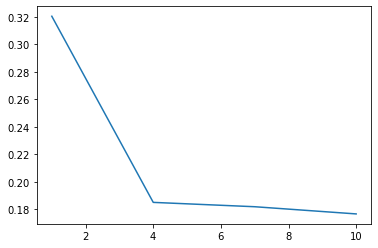

In [60]:
plt.plot([1, 4, 7, 10], np.array(energy_variance_clifford)/np.array(trace_ham_squared_clifford))

In [177]:
h = generator_function(5)

In [178]:
current_ham = h()

In [180]:
sbrg_object_test=BifurcationRG(
    hamiltonian=current_ham.copy(),
    growth_rate=1000,
)

sbrg_object_test.diagonalize()

local_cliffords = sbrg_object_test.give_cliffords_with_preserved_locality(cliffords_list=cliffords)

max_residual_term (0.9836513845358341+0j)*Z(24)
N 0
there is one z 1 [(cirq.LineQubit(24), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(24), cirq.LineQubit(0))]
last sigma term 0.191*X(0)*X(23)+0.002*X(0)*X(25)
max_residual_term (0.9251241007179231+0j)*Z(59)
N 1
there is one z 1 [(cirq.LineQubit(59), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(59), cirq.LineQubit(1))]
last sigma term 0.003*X(1)*X(58)+0.003*X(1)*X(60)
max_residual_term (0.9180694797869557+0j)*X(45)*X(46)
N 2
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(45), cirq.LineQubit(2)), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(45), cirq.Y), (cirq.LineQubit(46), cirq.X)}): -0.7071067811865475j, frozenset(): (0.7071067811865475+0j)}))]
last sigma term -0.002*X(2)*X(46)+0.326*Y(2)*Y(46)-0.261*X(2)*Z(44)*X(46)+0.227*Y(2)*Y(46)*Z(47)
max_residual_term (0.9154220835802076+0j)*X(4)*X(5)
N 3
heres the term and cli

last sigma term 0.118*X(18)*X(44)+0.072*Z(2)*X(18)*X(47)
max_residual_term (0.5296759707705954+0j)*Z(7)*Z(31)
N 19
there are multiple zs
[(cirq.LineQubit(7), cirq.Z), (cirq.LineQubit(31), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(31), cirq.LineQubit(19)), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(31), cirq.Y)}): -0.7071067811865475j, frozenset(): (0.7071067811865475+0j)})), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(31), cirq.Y), (cirq.LineQubit(7), cirq.Z)}): 0.7071067811865475j, frozenset(): (0.7071067811865475+0j)}))]
last sigma term 0.000
max_residual_term (0.4872813209010003+0j)*Z(23)
N 20
there is one z 1 [(cirq.LineQubit(23), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(23), cirq.LineQubit(20))]
last sigma term 0.123*X(20)*X(22)
max_residual_term (0.47874162864735686+0j)*Z(33)*Z(34)
N 21
there are multiple zs
[(cirq.LineQubit(33), cirq.Z), (cirq.LineQubit(34), cirq.Z)]

last sigma term 0.068*Y(40)*X(50)*Y(51)
max_residual_term (0.2557756162873363+0j)*Z(37)*Z(47)
N 41
there are multiple zs
[(cirq.LineQubit(37), cirq.Z), (cirq.LineQubit(47), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(47), cirq.LineQubit(41)), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(47), cirq.Y)}): -0.7071067811865475j, frozenset(): (0.7071067811865475+0j)})), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(37), cirq.Z), (cirq.LineQubit(47), cirq.Y)}): 0.7071067811865475j, frozenset(): (0.7071067811865475+0j)}))]
last sigma term 0.015*Z(2)*Z(18)*Z(37)*X(41)*X(44)
max_residual_term (0.23196570324167487+0j)*Z(33)*Z(48)
N 42
there are multiple zs
[(cirq.LineQubit(33), cirq.Z), (cirq.LineQubit(48), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(48), cirq.LineQubit(42)), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(48), cirq.Y)}): -0.7071067811865475j, frozenset(): (0.7071067

last sigma term 0.000
max_residual_term (0.03881036635343233+0j)*Z(0)*Z(14)*Z(34)*Z(60)
N 58
there are multiple zs
[(cirq.LineQubit(0), cirq.Z), (cirq.LineQubit(14), cirq.Z), (cirq.LineQubit(34), cirq.Z), (cirq.LineQubit(60), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(60), cirq.LineQubit(58)), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(60), cirq.Y)}): -0.7071067811865475j, frozenset(): (0.7071067811865475+0j)})), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(14), cirq.Z), (cirq.LineQubit(0), cirq.Z), (cirq.LineQubit(34), cirq.Z), (cirq.LineQubit(60), cirq.Y)}): 0.7071067811865475j, frozenset(): (0.7071067811865475+0j)}))]
last sigma term 0.000
max_residual_term (0.03438886053877234+0j)*Z(1)*Z(8)*Z(61)
N 59
there are multiple zs
[(cirq.LineQubit(1), cirq.Z), (cirq.LineQubit(8), cirq.Z), (cirq.LineQubit(61), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(61), cirq.LineQubit(59)), cirq

In [199]:
inverted_cliffords = sbrg_object_test.invert_cliffords(
    local_cliffords
)

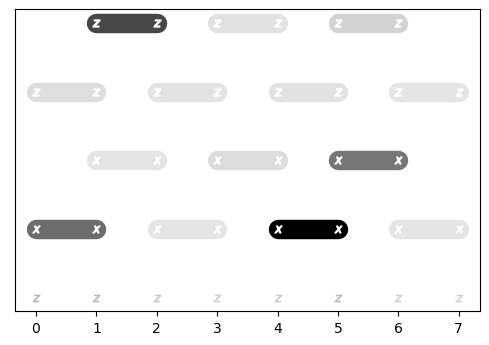

In [141]:
ttt = cirq.PauliSum()

for t in current_ham:
    if max(t.qubits).x<8:
        ttt+=t

f, a = visualize_hamiltonian(ttt)


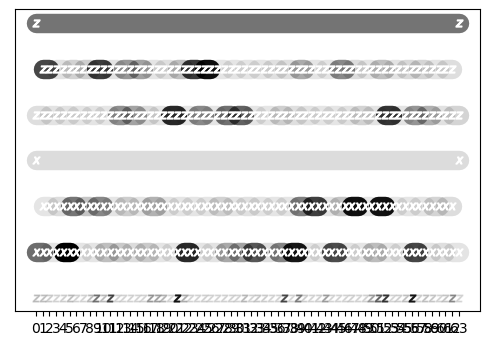

In [140]:
f, a = visualize_hamiltonian(current_ham)

#a.set_aspect(1)

In [181]:
dh1, dh2 = get_diagonalized_hams(
    current_ham,
    growth_rate=1000,
)

max_residual_term (0.9836513845358341+0j)*Z(24)
N 0
there is one z 1 [(cirq.LineQubit(24), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(24), cirq.LineQubit(0))]
last sigma term 0.191*X(0)*X(23)+0.002*X(0)*X(25)
max_residual_term (0.9251241007179231+0j)*Z(59)
N 1
there is one z 1 [(cirq.LineQubit(59), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(59), cirq.LineQubit(1))]
last sigma term 0.003*X(1)*X(58)+0.003*X(1)*X(60)
max_residual_term (0.9180694797869557+0j)*X(45)*X(46)
N 2
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(45), cirq.LineQubit(2)), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(45), cirq.Y), (cirq.LineQubit(46), cirq.X)}): -0.7071067811865475j, frozenset(): (0.7071067811865475+0j)}))]
last sigma term -0.002*X(2)*X(46)+0.326*Y(2)*Y(46)-0.261*X(2)*Z(44)*X(46)+0.227*Y(2)*Y(46)*Z(47)
max_residual_term (0.9154220835802076+0j)*X(4)*X(5)
N 3
heres the term and cli

last sigma term 0.118*X(18)*X(44)+0.072*Z(2)*X(18)*X(47)
max_residual_term (0.5296759707705954+0j)*Z(7)*Z(31)
N 19
there are multiple zs
[(cirq.LineQubit(7), cirq.Z), (cirq.LineQubit(31), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(31), cirq.LineQubit(19)), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(31), cirq.Y)}): -0.7071067811865475j, frozenset(): (0.7071067811865475+0j)})), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(31), cirq.Y), (cirq.LineQubit(7), cirq.Z)}): 0.7071067811865475j, frozenset(): (0.7071067811865475+0j)}))]
last sigma term 0.000
max_residual_term (0.4872813209010003+0j)*Z(23)
N 20
there is one z 1 [(cirq.LineQubit(23), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(23), cirq.LineQubit(20))]
last sigma term 0.123*X(20)*X(22)
max_residual_term (0.47874162864735686+0j)*Z(33)*Z(34)
N 21
there are multiple zs
[(cirq.LineQubit(33), cirq.Z), (cirq.LineQubit(34), cirq.Z)]

last sigma term 0.068*Y(40)*X(50)*Y(51)
max_residual_term (0.2557756162873363+0j)*Z(37)*Z(47)
N 41
there are multiple zs
[(cirq.LineQubit(37), cirq.Z), (cirq.LineQubit(47), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(47), cirq.LineQubit(41)), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(47), cirq.Y)}): -0.7071067811865475j, frozenset(): (0.7071067811865475+0j)})), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(37), cirq.Z), (cirq.LineQubit(47), cirq.Y)}): 0.7071067811865475j, frozenset(): (0.7071067811865475+0j)}))]
last sigma term 0.015*Z(2)*Z(18)*Z(37)*X(41)*X(44)
max_residual_term (0.23196570324167487+0j)*Z(33)*Z(48)
N 42
there are multiple zs
[(cirq.LineQubit(33), cirq.Z), (cirq.LineQubit(48), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(48), cirq.LineQubit(42)), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(48), cirq.Y)}): -0.7071067811865475j, frozenset(): (0.7071067

last sigma term 0.000
max_residual_term (0.03881036635343233+0j)*Z(0)*Z(14)*Z(34)*Z(60)
N 58
there are multiple zs
[(cirq.LineQubit(0), cirq.Z), (cirq.LineQubit(14), cirq.Z), (cirq.LineQubit(34), cirq.Z), (cirq.LineQubit(60), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(60), cirq.LineQubit(58)), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(60), cirq.Y)}): -0.7071067811865475j, frozenset(): (0.7071067811865475+0j)})), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(14), cirq.Z), (cirq.LineQubit(0), cirq.Z), (cirq.LineQubit(34), cirq.Z), (cirq.LineQubit(60), cirq.Y)}): 0.7071067811865475j, frozenset(): (0.7071067811865475+0j)}))]
last sigma term 0.000
max_residual_term (0.03438886053877234+0j)*Z(1)*Z(8)*Z(61)
N 59
there are multiple zs
[(cirq.LineQubit(1), cirq.Z), (cirq.LineQubit(8), cirq.Z), (cirq.LineQubit(61), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(61), cirq.LineQubit(59)), cirq

In [182]:
def break_up_ham(ham):
    
    off_diag = cirq.PauliSum()
    diag = cirq.PauliSum()
    
    for term in ham:
        
        if {cirq.X, cirq.Y}.intersection(set(term.values())):
            off_diag += term
        else:
            diag += term
    
    return off_diag, diag

In [183]:
offdag, diag = break_up_ham(dh2)

In [184]:
len(diag)

93

In [185]:
print(np.sum([np.real(term.coefficient)**2 for term in diag]))
print(np.sum([np.real(term.coefficient)**2 for term in offdag]))

15.347478211054174
2.805416456768076


(<Figure size 600x400 with 1 Axes>, <AxesSubplot:>)

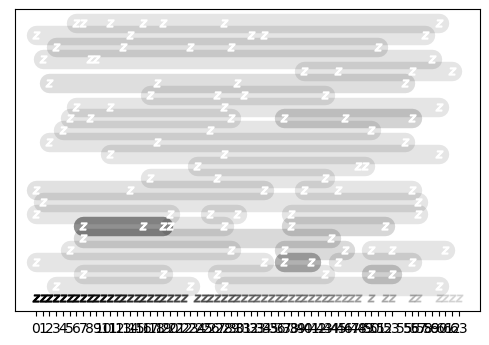

In [186]:
visualize_hamiltonian(diag)

# below we have lioms


In [200]:
liom = sbrg_object_test.apply_clifford_diagonalization(
    cirq.PauliSum() + cirq.Z(cirq.LineQubit(0)) + 1*cirq.Z(cirq.LineQubit(10))+2*cirq.Z(cirq.LineQubit(20))+3*cirq.Z(cirq.LineQubit(30))+3*cirq.Z(cirq.LineQubit(40))+4*cirq.Z(cirq.LineQubit(50)),
    cliffords_list=inverted_cliffords,
)

In [201]:
liom

cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(0), cirq.Z)}): (0.9999999999999875+0j), frozenset({(cirq.LineQubit(9), cirq.X), (cirq.LineQubit(10), cirq.X)}): (0.9999999999999875+0j), frozenset({(cirq.LineQubit(21), cirq.Z)}): (1.999999999999975+0j), frozenset({(cirq.LineQubit(30), cirq.X), (cirq.LineQubit(31), cirq.X)}): (2.999999999999969+0j), frozenset({(cirq.LineQubit(38), cirq.Y), (cirq.LineQubit(40), cirq.Y), (cirq.LineQubit(39), cirq.Z)}): (-2.999999999999969+0j), frozenset({(cirq.LineQubit(50), cirq.Z)}): (3.99999999999995+0j)}))

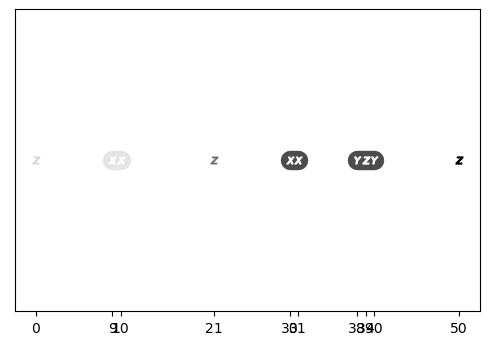

In [202]:
f, a = visualize_hamiltonian(liom)

(<Figure size 600x400 with 1 Axes>, <AxesSubplot:>)

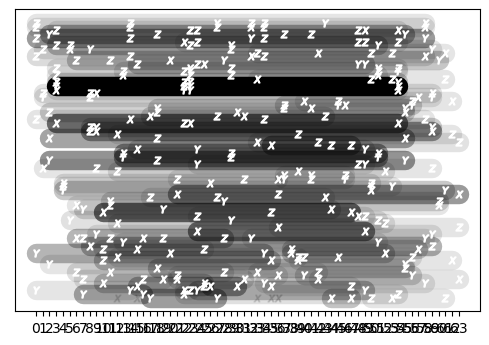

In [187]:
visualize_hamiltonian(offdag)

In [188]:
print(np.sum([t.coefficient**2 for t in offdag])/np.sum([t.coefficient**2 for t in diag]))

(0.18279331745507524+0j)


In [192]:
corrected_hamiltonian = obtain_corrected_hamiltonian(
    hamiltonian=current_ham,
)

max_residual_term (0.9836513845358341+0j)*Z(24)
N 0
there is one z 1 [(cirq.LineQubit(24), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(24), cirq.LineQubit(0))]
last sigma term 0.191*X(0)*X(23)+0.002*X(0)*X(25)
max_residual_term (0.9251241007179231+0j)*Z(59)
N 1
there is one z 1 [(cirq.LineQubit(59), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(59), cirq.LineQubit(1))]
last sigma term 0.003*X(1)*X(58)+0.003*X(1)*X(60)
max_residual_term (0.9180694797869557+0j)*X(45)*X(46)
N 2
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(45), cirq.LineQubit(2)), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(45), cirq.Y), (cirq.LineQubit(46), cirq.X)}): -0.7071067811865475j, frozenset(): (0.7071067811865475+0j)}))]
last sigma term -0.002*X(2)*X(46)+0.326*Y(2)*Y(46)-0.261*X(2)*Z(44)*X(46)+0.227*Y(2)*Y(46)*Z(47)
max_residual_term (0.9154220835802076+0j)*X(4)*X(5)
N 3
heres the term and cli

last sigma term 0.118*X(18)*X(44)+0.072*Z(2)*X(18)*X(47)
max_residual_term (0.5296759707705954+0j)*Z(7)*Z(31)
N 19
there are multiple zs
[(cirq.LineQubit(7), cirq.Z), (cirq.LineQubit(31), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(31), cirq.LineQubit(19)), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(31), cirq.Y)}): -0.7071067811865475j, frozenset(): (0.7071067811865475+0j)})), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(31), cirq.Y), (cirq.LineQubit(7), cirq.Z)}): 0.7071067811865475j, frozenset(): (0.7071067811865475+0j)}))]
last sigma term 0.000
max_residual_term (0.4872813209010003+0j)*Z(23)
N 20
there is one z 1 [(cirq.LineQubit(23), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(23), cirq.LineQubit(20))]
last sigma term 0.123*X(20)*X(22)
max_residual_term (0.47874162864735686+0j)*Z(33)*Z(34)
N 21
there are multiple zs
[(cirq.LineQubit(33), cirq.Z), (cirq.LineQubit(34), cirq.Z)]

last sigma term 0.068*Y(40)*X(50)*Y(51)
max_residual_term (0.2557756162873363+0j)*Z(37)*Z(47)
N 41
there are multiple zs
[(cirq.LineQubit(37), cirq.Z), (cirq.LineQubit(47), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(47), cirq.LineQubit(41)), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(47), cirq.Y)}): -0.7071067811865475j, frozenset(): (0.7071067811865475+0j)})), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(37), cirq.Z), (cirq.LineQubit(47), cirq.Y)}): 0.7071067811865475j, frozenset(): (0.7071067811865475+0j)}))]
last sigma term 0.015*Z(2)*Z(18)*Z(37)*X(41)*X(44)
max_residual_term (0.23196570324167487+0j)*Z(33)*Z(48)
N 42
there are multiple zs
[(cirq.LineQubit(33), cirq.Z), (cirq.LineQubit(48), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(48), cirq.LineQubit(42)), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(48), cirq.Y)}): -0.7071067811865475j, frozenset(): (0.7071067

last sigma term 0.000
max_residual_term (0.03881036635343233+0j)*Z(0)*Z(14)*Z(34)*Z(60)
N 58
there are multiple zs
[(cirq.LineQubit(0), cirq.Z), (cirq.LineQubit(14), cirq.Z), (cirq.LineQubit(34), cirq.Z), (cirq.LineQubit(60), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(60), cirq.LineQubit(58)), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(60), cirq.Y)}): -0.7071067811865475j, frozenset(): (0.7071067811865475+0j)})), cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.LineQubit(14), cirq.Z), (cirq.LineQubit(0), cirq.Z), (cirq.LineQubit(34), cirq.Z), (cirq.LineQubit(60), cirq.Y)}): 0.7071067811865475j, frozenset(): (0.7071067811865475+0j)}))]
last sigma term 0.000
max_residual_term (0.03438886053877234+0j)*Z(1)*Z(8)*Z(61)
N 59
there are multiple zs
[(cirq.LineQubit(1), cirq.Z), (cirq.LineQubit(8), cirq.Z), (cirq.LineQubit(61), cirq.Z)]
heres the term and clifford
this is the clifford [cirq.SWAP(cirq.LineQubit(61), cirq.LineQubit(59)), cirq

(<Figure size 600x400 with 1 Axes>, <AxesSubplot:>)

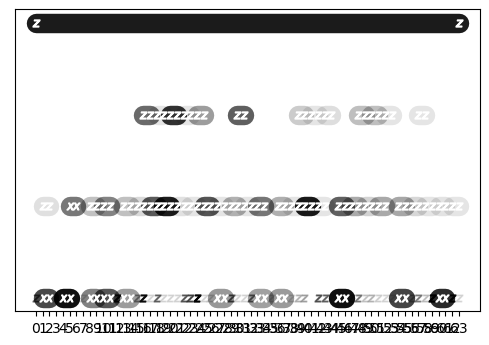

In [193]:
visualize_hamiltonian(corrected_hamiltonian)

In [194]:
def connected_components(ham):
    """
    """
    ccs = []
    
    for term in ham:
        
        xs = set([q.x for q in term.qubits])
        
        current_cc = set([q.x for q in term.qubits])
        other_ccs = []
        
        for cc in ccs:
            if xs.intersection(cc):
                current_cc = current_cc.union(cc)
            else:
                other_ccs.append(cc)
        
        ccs = other_ccs+[current_cc]
    
    local_terms = [cirq.PauliSum() for _ in ccs]
    
    for term in ham:
        
        xs = set([q.x for q in term.qubits])
        
        done = False
        
        for i, cc in enumerate(ccs):
            if xs.intersection(cc):
                assert not done
                local_terms[i]+=term
                
                done = True
            
    
    
    return ccs, local_terms

In [195]:
ccs, local_terms = connected_components(corrected_hamiltonian)

In [196]:
sorted(ccs, key = len)

[{3},
 {7},
 {12},
 {35},
 {1, 2},
 {8, 9},
 {10, 11},
 {13, 14},
 {27, 28},
 {33, 34},
 {36, 37},
 {45, 46},
 {54, 55},
 {60, 61},
 {4, 5, 6},
 {0, 62, 63},
 {29, 30, 31, 32},
 {56, 57, 58, 59},
 {38, 39, 40, 41, 42, 43, 44},
 {47, 48, 49, 50, 51, 52, 53},
 {15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}]

In [197]:
np.sum(local_terms) - corrected_hamiltonian

cirq.PauliSum(cirq.LinearDict({}))

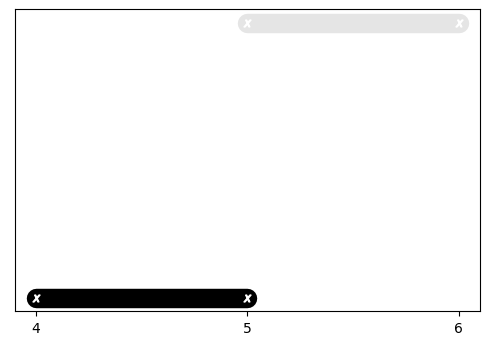

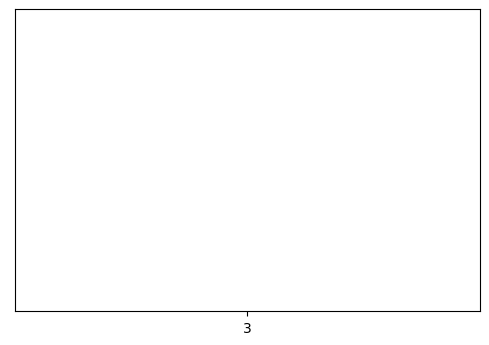

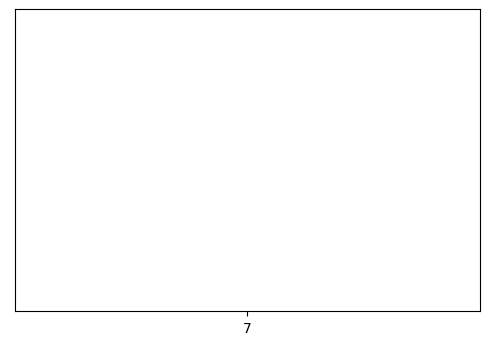

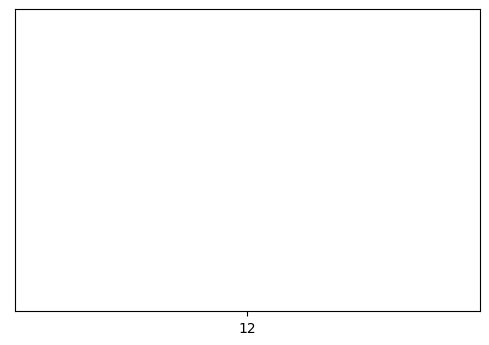

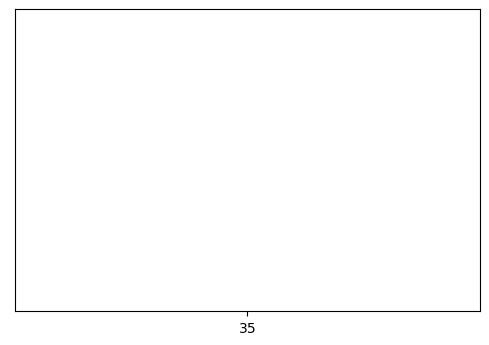

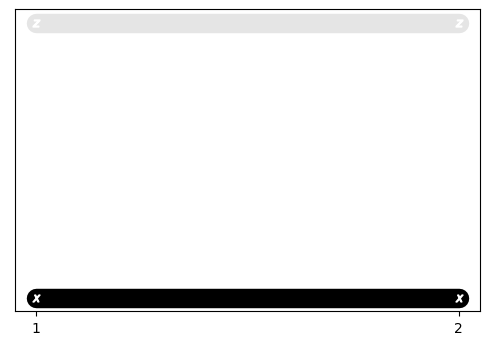

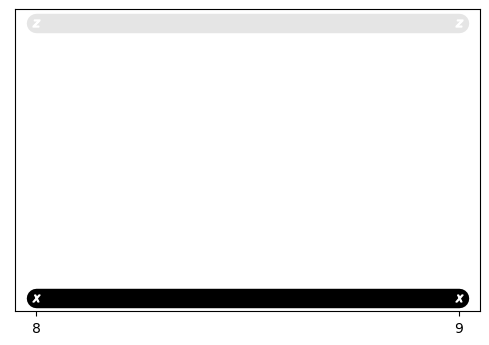

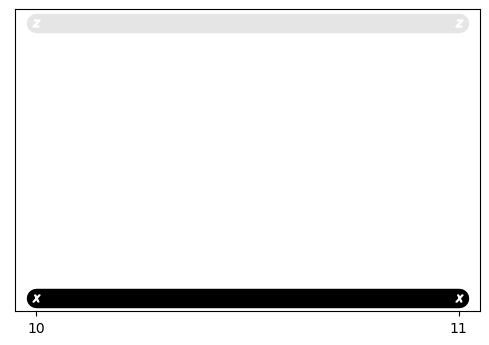

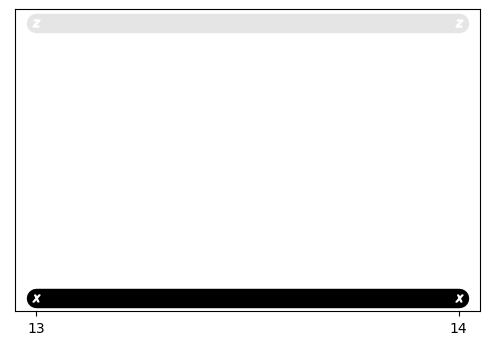

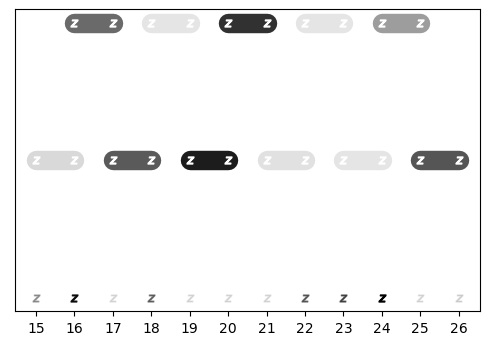

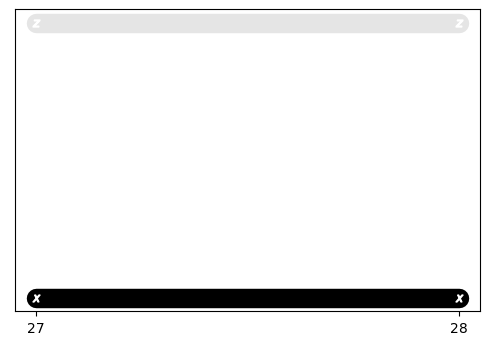

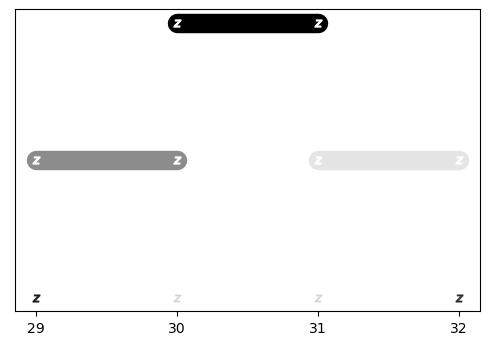

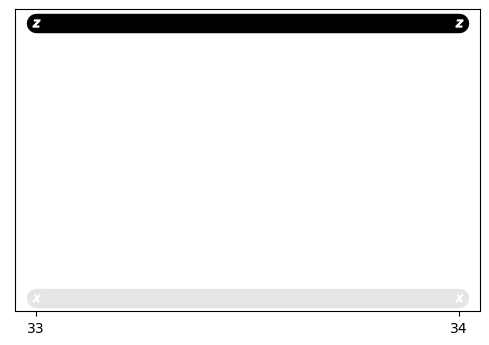

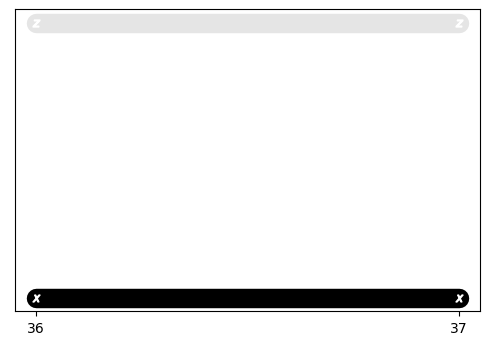

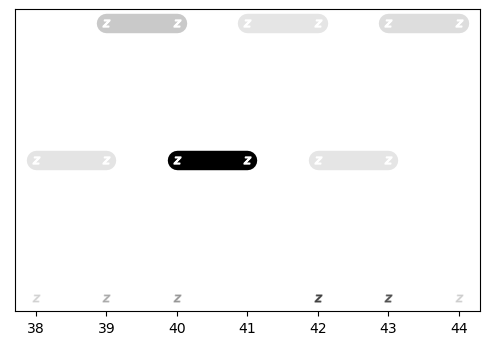

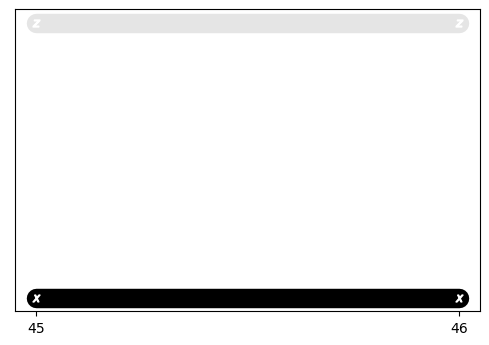

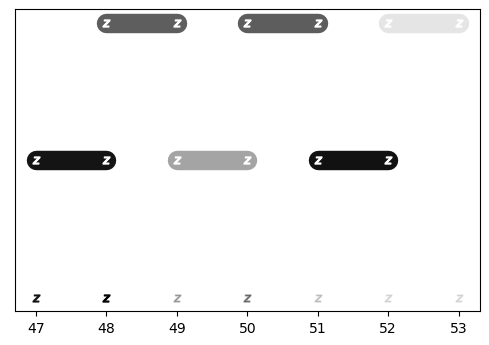

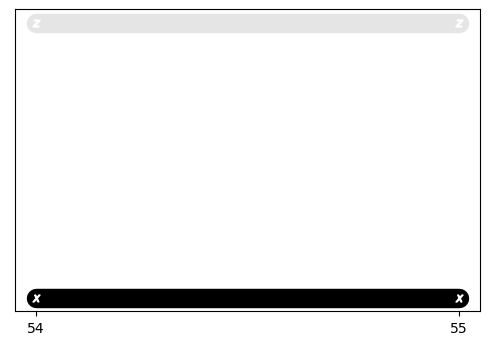

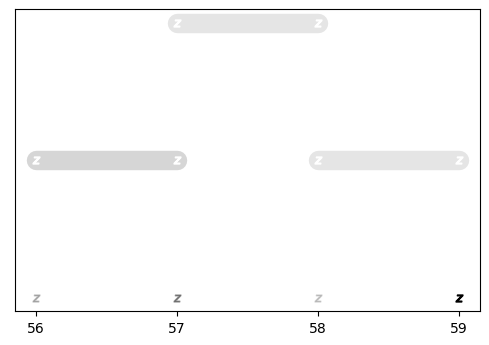

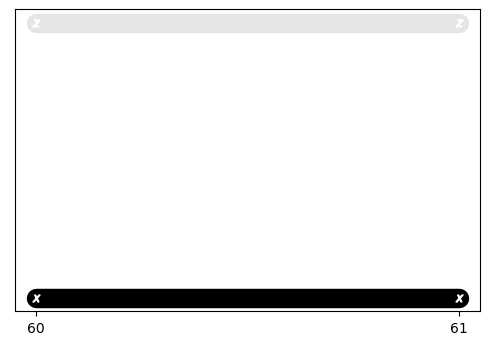

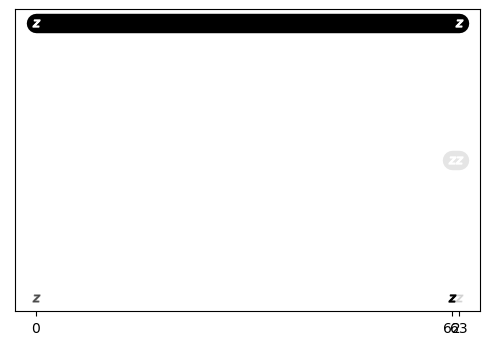

In [198]:
for t in local_terms:
    visualize_hamiltonian(t)

(<Figure size 600x400 with 1 Axes>, <AxesSubplot:>)

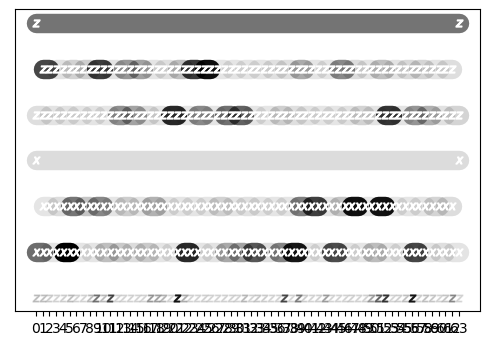

In [133]:
visualize_hamiltonian(current_ham)

In [134]:
np.array(c[1:])/np.array(d[1:])

array([2.83838988+0.j, 2.83902864+0.j, 2.75750902+0.j])

In [95]:
h = {1,2, 3}.union({2, 3, 4})


In [96]:
h

{1, 2, 3, 4}

In [ ]:
ham1, ham2 = test_clifford_inversion(
    hamiltonian=test_ham,
    test_hamiltonian=test_ham_2,
    preserve_locality=False,
)

In [ ]:
h2 = (ham2**2)

In [ ]:
for k in vars(h2):
    print(k)

In [ ]:
for t in h2:
    print(t)

In [ ]:
h2._linear_dict[frozenset()]

In [ ]:
h2

In [ ]:
print(sorted([np.abs(term.coefficient) for term in ham2]))

In [ ]:
visualize_hamiltonian(ham1-ham2)

In [ ]:
corrected_hamiltonian, clifford_diagonalized_hamiltonian, dp, opd = obtain_corrected_hamiltonian(
    hamiltonian=test_ham,
    return_diagonalized_hamiltonian=True,
)

In [ ]:
visualize_hamiltonian(opd)

In [ ]:
visualize_hamiltonian(dp)

In [ ]:
visualize_hamiltonian(corrected_hamiltonian)


In [ ]:
visualize_hamiltonian(dp+opd)

In [ ]:
visualize_hamiltonian(test_ham)

In [ ]:
visualize_hamiltonian(clifford_diagonalized_hamiltonian)